In [1]:
import random
from random import choice
import numpy as np
import pandas as pd
from transformers import BertTokenizer,  BertConfig, TFBertModel
import tensorflow as tf
from tensorflow.keras import backend as K
import os

# 数据集整理
## 读取数据

In [2]:
def json_to_df(path, nrows=False):
    if nrows:
        df = pd.read_json(path, nrows=nrows, lines=True)
    else:
        df = pd.read_json(path, lines=True)
    df = df[['text', 'spo_list']]
    return df

def merge_df(dir_path):
    total_df = pd.DataFrame()
    for fn in os.listdir(dir_path):
        df = json_to_df(os.path.join(dir_path, fn))
        df_fn = fn[:fn.rfind('.')]
        df.insert(0, 'fn', df_fn)
        total_df =  total_df.append(df)
    total_df.reset_index(drop=True, inplace=True)
    print(f'data size: {total_df.shape}') #
    print(f'data sample: {df.sample(5)}')
    return total_df   

def read_schemads(path_or_df):
    if not isinstance(path_or_df, pd.DataFrame):
        print(1)
        schemads_path = path_or_df
        predicate_data = pd.read_json(schemads_path, lines=True)
        id2p = predicate_data['predicate'].drop_duplicates().reset_index(drop=True).to_dict()
    else:
        df = path_or_df
        id2p = df['spo_list'].apply(lambda spo_list: [spo['predicate'] for spo in spo_list])
        id2p = id2p.explode().drop_duplicates().reset_index(drop=True).to_dict()
    p2id = dict(zip(id2p.values(), id2p.keys()))
    print(f'length of p2id :{len(p2id)}')#
    print(f'random p2id sample:{random.sample(p2id.items(), 5)}')#
    return id2p, p2id

In [5]:
# %%time
# # 百度三元组关系数据集
# train_path ='../data/百度关系抽取数据集/train_data.json'
# train_data = json_to_df(train_path, nrows=10000)
# print(f'Train data size: {train_data.shape}') #

# dev_path = '../data/百度关系抽取数据集/dev_data.json'
# dev_data = json_to_df(dev_path, nrows=5000)
# print(f'Validation data size: {dev_data.shape}') 

# schemads_path = '../data/百度关系抽取数据集/all_50_schemas'
# id2p, p2id = read_schemads(schemads_path)#

In [3]:
## 招股说明书三元组数据集
dir_path = '../data/招股说明书三元组数据集'
df = merge_df(dir_path)
id2p, p2id = read_schemads(df)

data size: (10698, 3)
data sample:                    fn                                               text  \
113  阿科力首次公开发行股票招股说明书  2015年6月5日，公司召开2015年第一次临时股东大会，选举丁玉强、冯凯燕、单世文担任第一...   
57   阿科力首次公开发行股票招股说明书  崔小丽，女，1966年3月出生，中国国籍，无境外永久居留权，本科学历。身份证号码为32062...   
100  阿科力首次公开发行股票招股说明书  2013年1月，朱学军以1.45元/股将其持有公司的80万元和30万元股权分别转让给诚鼎创投...   
36   阿科力首次公开发行股票招股说明书  2015年，财务费用较上年下降158.43万元，主要原因是：由于公司业绩持续快速增长，并采用...   
49   阿科力首次公开发行股票招股说明书  2008年7月1日，经公司股东会决议批准，将原注册资本1,000万元增资至6,000万元，其...   

                                              spo_list  
113  [{'predicate': '任职日期', 'object_type': '日期', 's...  
57   [{'predicate': '出生日期', 'object_type': '日期', 's...  
100  [{'predicate': '转让日期', 'object_type': '日期', 's...  
36   [{'predicate': '财务费用', 'object_type': '金额', 's...  
49   [{'predicate': '注册资本', 'object_type': '金额', 's...  
length of p2id :116
random p2id sample:[('应付职工薪酬', 62), ('存货周转率', 76), ('应收合计', 69), ('长期待摊费用', 102), ('固定资产', 84)]


## 清洗数据

In [5]:
def clean_spo(spo_list):
    for spo in spo_list:
        spo['predicate'] = spo['predicate'].lower()
        spo['subject'] = spo['subject'].lower()
        spo['object'] = spo['object'].lower()
    return spo_list

def data_clean(df):
    df.dropna(how='any', inplace=True)
    df = df[df['spo_list'].apply(lambda x: len(x)>0)]
    df.drop_duplicates(subset=['text'], inplace=True)
    df.reset_index(drop=True, inplace=True)
    df['text'] = df['text'].str.lower()
    df['spo_list'] = df['spo_list'].apply(clean_spo)
    print(f'Real data size is {df.shape[0]}')
    return df

In [6]:
df = data_clean(df)
# train_data = data_clean(train_data)
# dev_data = data_clean(dev_data)

Real data size is 8436


ipykernel_launcher:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipykernel_launcher:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipykernel_launcher:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## 划分数据集

In [7]:
train_size=0.9

train_data = df.sample(frac=train_size,random_state=200)
dev_data = df.drop(train_data.index)
dev_data.reset_index(drop=True, inplace=True)
train_data.reset_index(drop=True, inplace=True)
print(f'Train data size: {train_data.shape}') #
print(f'Validation data size: {dev_data.shape}') 

spo_single_count = df['spo_list'].apply(lambda x: len(x))
spo_count = spo_single_count.sum()
print('spo_count', spo_count)

Train data size: (7592, 3)
Validation data size: (844, 3)
spo_count 24451


In [10]:
train_text = train_data['text'].to_list()
train_spo = train_data['spo_list'].to_list()
                                                
dev_text = dev_data['text'].to_list()
dev_spo = dev_data['spo_list'].to_list()

spo_count 24451


## 标签集分布情况

       spo_list  count  compliance 
0  主营业务成本-日期-金额     33            0
1  主营业务收入-日期-金额    233            1
2    任职公司-人物-公司   3243            0
3    任职公司-人物-日期      1            0
4    任职日期-人物-日期   3160            0


<AxesSubplot:>

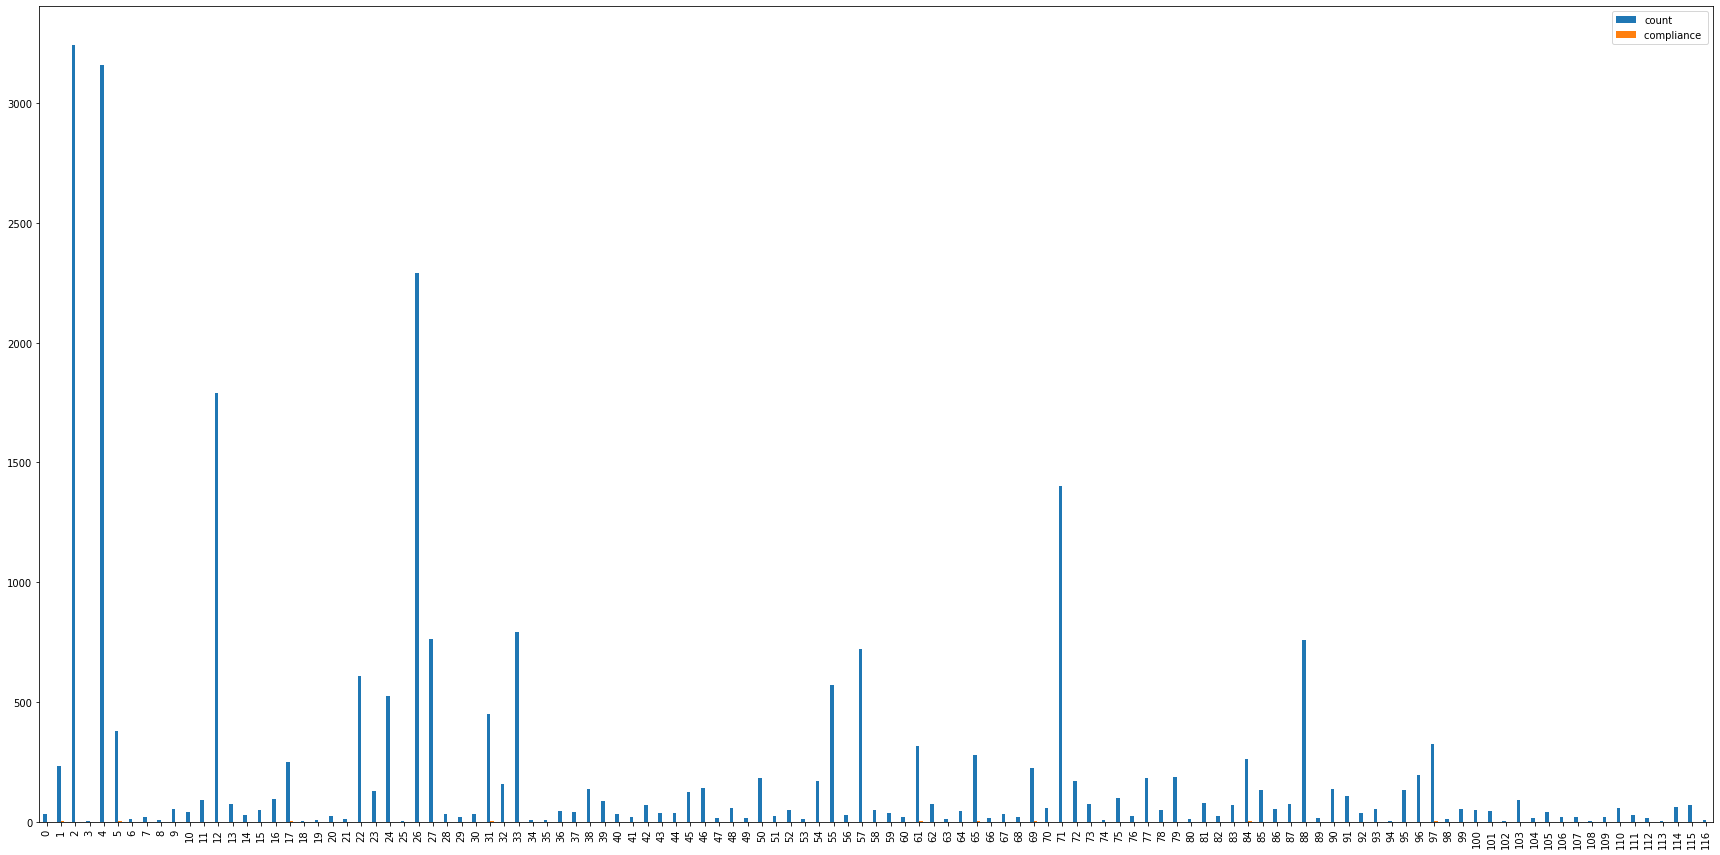

In [10]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

dataset_name = '招股说明书'
spo = df['spo_list'].explode().reset_index(drop=True)
spo_group = spo.apply(lambda x: '-'.join([x['predicate'] , x['subject_type'], x['object_type']]))
spo_group_count = spo_group.groupby(spo_group).count().reset_index(name='count')
spo_group_count['compliance '] = spo_group_count['count'].apply(lambda x: 1 if 200<x<500 else 0)
print(spo_group_count.head())
spo_group_count.to_csv('../data/' + dataset_name + '_spo_group_count.csv', index=False, encoding='utf_8_sig')
spo_group_count.plot(kind='bar', figsize=(30,15))

## 数据集处理

In [11]:
def find_head_idx(pattern, sequence):
    """从sequence中寻找子串pattern
    如果找到，返回第一个下标；否则返回-1。
    """
    n = len(pattern)
    for i in range(len(sequence)):
        if sequence[i:i + n] == pattern:
            return i
    return -1

In [12]:
def data_process(df, p2id, tokenizer, max_length):
    long_text_count = 0
    total_token_ids, total_token_type_ids, total_attention_mask = [], [], []
    total_subject_labels, total_subject_ids, total_object_labels = [], [], []
    for idx in df.index:
        row = df.loc[idx]
        inputs = tokenizer(row['text'], max_length=max_length, padding='max_length', truncation=True)
        token_ids, token_type_ids, attention_mask = inputs['input_ids'], inputs['token_type_ids'], inputs['attention_mask']
        # 实体关系token id 位置字典
        s2op_map = {}
        for sop_n, spo in enumerate(row['spo_list']):
            sub_ids = tokenizer.encode(spo['subject'])[1:-1]
            p_id = p2id[spo['predicate']]
            obj_ids = tokenizer.encode(spo['object'])[1:-1]
            # 查找subject 和 object对应的token id 起始索引
            sub_head_idx = find_head_idx(sub_ids, inputs['input_ids'])
            obj_head_idx = find_head_idx(obj_ids, inputs['input_ids'])
            if sub_head_idx != -1 and obj_head_idx != -1:
                # 获取subject 起始位置的索引和结束位置索引的元组
                sub = (sub_head_idx, sub_head_idx + len(sub_ids) - 1)
                # 获取object 起始位置的索引和结束位置索引元组以及与关系标签id的元组对
                obj = (obj_head_idx, obj_head_idx + len(obj_ids) - 1, p_id)
                # print('---- sub -----', sub)#    
                if sub not in s2op_map:
                    s2op_map[sub] = []
                s2op_map[sub].append(obj)
                # print('-----------', s2op_map)#                
                {(22,23):[(28, 29, 7), (25, 26, 8)]}  
            else:
                long_text_count +=1
                # print('--idx--', idx, '--text--', row['text'])
                # print('--sop_n--', sop_n, '--spo--', spo, '\n')


        if s2op_map:
        # subject标签
            subject_labels = np.zeros((max_length, 2))
            for s in s2op_map:
                #sub_head
                subject_labels[s[0], 0] = 1
                #sub_tail
                subject_labels[s[1], 1] = 1
            # 随机选一个subject
            sub_head, sub_tail = choice(list(s2op_map.keys()))
            subject_ids = (sub_head, sub_tail)
            # sub_head, sub_tail = np.array(list(s2op_map.keys())).T
            # sub_head = np.random.choice(sub_head)
            # sub_tail = np.random.choice(sub_tail[sub_tail >= sub_head])
            # 对应的object标签
            object_labels = np.zeros((len(token_ids), len(p2id), 2))
            for op in s2op_map.get((sub_head, sub_tail), []):
                # print(op)
                # obj_head
                object_labels[op[0], op[2], 0] = 1
                # obj_tail
                object_labels[op[1], op[2], 1] = 1

            # 所有数据汇总
            total_token_ids.append(token_ids)
            total_token_type_ids.append(token_type_ids)
            total_attention_mask.append(attention_mask)
            total_subject_labels.append(subject_labels)
            total_subject_ids.append(subject_ids)
            total_object_labels.append(object_labels)  
    print('long_text_count', long_text_count)                      
    return total_token_ids, total_token_type_ids, total_attention_mask, \
           total_subject_labels, total_subject_ids, total_object_labels

In [13]:
# input_demo = data_process(train_data[3:4], p2id, tokenizer, max_length)
# print(np.array(input_demo[5]).shape)
# print(train_spo[3])
# print(np.array(input_demo[5])[0, 25, 14, 0], np.array(input_demo[5])[0, 27, 14, 1])
# print(np.array(input_demo[5])[0, 14, 17, 0], np.array(input_demo[5])[0, 14, 17, 1])
# # tokenizer.decode(train_input_ids[3][op_s:op_e+1])
# print(train_spo[3])

In [14]:
%%time
model_path = '../model_dirs/bert-base-chinese'  
tokenizer = BertTokenizer.from_pretrained(model_path)
max_length = 512
train_input_ids, train_token_type_ids, train_attention_mask, train_subject_labels, train_subject_ids, train_object_labels  = data_process(train_data, p2id, tokenizer, max_length)
print(train_subject_ids[:2])
print(np.array(train_subject_labels).shape)

long_text_count 181
[(48, 49), (1, 3)]
(7521, 512, 2)
Wall time: 18.1 s


In [15]:
%%time
val_inputs = tokenizer(dev_text, max_length=max_length, padding='max_length', truncation=True, return_tensors='tf') 
val_input_ids, val_attention_mask = val_inputs['input_ids'], val_inputs['attention_mask']

Wall time: 1.29 s


In [16]:
ix = 1178
text = train_data.loc[ix,'text']
print(len(text), text)
sub = train_data.loc[ix,'spo_list'][0]['subject']
obj = train_data.loc[ix,'spo_list'][0]['object']
print(sub, obj)
max_length = 256
s_ids = tokenizer.encode(sub, max_length=max_length, truncation=True)[1:-1]
o_ids = tokenizer.encode(obj, max_length=max_length, truncation=True)[1:-1]
text_ids = tokenizer.encode(text, max_length=max_length, padding='max_length', truncation=True)
print(text_ids)
print(s_ids)
print(o_ids)
find_head_idx(s_ids, text_ids), find_head_idx(o_ids, text_ids)

181 2009年12月，经重庆市国资委批准，重钢集团发起设立发行人前身重钢环保。重钢环保成立后，为优化管理架构、做大做强环保产业，将重钢环保打造为下属环保产业的投资、管理平台，重钢集团对其所属环保产业进行了重组，将其所持有的重庆丰盛100%的股权、三峰科技60%的股权、三峰卡万塔60%的股权、成都九江51%的股权和重庆同兴9.9%的股权以股权增资的方式注入重钢环保。
重钢集团 重钢环保
[101, 8170, 2399, 8110, 3299, 8024, 5307, 7028, 2412, 2356, 1744, 6598, 1999, 2821, 1114, 8024, 7028, 7167, 7415, 1730, 1355, 6629, 6392, 4989, 1355, 6121, 782, 1184, 6716, 7028, 7167, 4384, 924, 511, 7028, 7167, 4384, 924, 2768, 4989, 1400, 8024, 711, 831, 1265, 5052, 4415, 3373, 3354, 510, 976, 1920, 976, 2487, 4384, 924, 772, 689, 8024, 2199, 7028, 7167, 4384, 924, 2802, 6863, 711, 678, 2247, 4384, 924, 772, 689, 4638, 2832, 6598, 510, 5052, 4415, 2398, 1378, 8024, 7028, 7167, 7415, 1730, 2190, 1071, 2792, 2247, 4384, 924, 772, 689, 6822, 6121, 749, 7028, 5299, 8024, 2199, 1071, 2792, 2898, 3300, 4638, 7028, 2412, 705, 4670, 8135, 110, 4638, 5500, 3326, 510, 676, 2292, 4906, 2825, 8183, 110, 4638, 5500, 3326, 510, 676, 2292, 1305, 674, 1849, 8183, 110, 4638, 5500, 3326, 510, 2768, 6963, 736

(16, 29)

In [17]:
## debug
model_path = '../model_dirs/bert-base-chinese'  
tokenizer = BertTokenizer.from_pretrained(model_path)
max_length = 128
print(f"text ---\n {train_data.loc[47:100,'text']}")
inputs = tokenizer(train_data.loc[47:100,'text'].to_list(), max_length=max_length, padding='max_length', return_tensors='tf', truncation=True)
print('inputs keys --\n', inputs.keys())
print(f"input_ids --\n {inputs['input_ids']}")
tokens = tokenizer.decode(inputs['input_ids'][0])
print('tokens --\n', tokens)
print(f"spo_list ------\n {train_data.loc[47,'spo_list']}")
text_len = len(tokens)
text_len
bert_model = TFBertModel.from_pretrained(model_path, output_hidden_states=True)
outputs = bert_model(inputs)
last_hidden_state, pooler_output, hidden_states = outputs[:3]

text ---
 47      近年来，全球软件用户群体快速增长，据wearesocial和hootsuite联合发布的《d...
3608    2014年6月9日，天鹅股份召开第三届董事会第二十一次会议，审议通过了《关于转让图木舒克市天...
5045    宝应锦程村镇银行主营业务为银行业务。截至2016年12月31日，宝应锦程村镇银行总资产为56...
2499    公司2020年度、2019年度、2018年度的非经常性损益净额分别为1,237.73万元、1...
7074    殷奇先生，39岁，本科，工程师，一级项目经理。1984年在上海城建学院参加工作，1995年到...
                              ...                        
1856    黄军林先生，汉族，1974年出生，中国国籍，无境外永久居留权。东南大学学士。曾就职于上海长江...
7432    除因邵毅平辞任独立董事于2015年8月28日股东大会选举杨鹰彪为公司独立董事、因胡雄辞任监事...
380     公司成立于1996年11月，设立时名称为海宁市马桥华生经编针织厂；华生针织厂于2005年5月...
7148    资产总额逐年增长。2013年末、2014年末、2015年末及2016年6月末，公司资产总额分...
100         最近三年，公司公允价值变动收益分别为77.36万元、-89.08万元及-109.08万元，
Name: text, Length: 3554, dtype: object
inputs keys --
 dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
input_ids --
 [[ 101 6818 2399 ...    0    0    0]
 [ 101 8127 2399 ...    0    0    0]
 [ 101 2140 2418 ...    0    0    0]
 ...
 [ 101 1062 1385 ...    0    0    0]
 [ 101 6598  772 ... 5763 5709  102]
 [ 101 3297 6818 ...    0    0 

Some layers from the model checkpoint at ../model_dirs/bert-base-chinese were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at ../model_dirs/bert-base-chinese.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


ResourceExhaustedError: OOM when allocating tensor with shape[3554,128,768] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Tile]

In [ ]:
hidden_states[-1].shape

TensorShape([54, 128, 768])

In [ ]:
def extract_subject(output, subject_ids):
    start = tf.gather(output, subject_ids[:,:1], batch_dims=1)
    end = tf.gather(output, subject_ids[:,1:], batch_dims=1)
    subject = tf.keras.layers.Concatenate(axis=2)([start, end])
    return subject[:, 0]

extract_subject(hidden_states[-1], tf.constant(train_subject_ids[:hidden_states[-1].shape[0]]))

<tf.Tensor: shape=(54, 1536), dtype=float32, numpy=
array([[ 0.25873297,  0.49238703,  0.63826686, ...,  0.11304718,
        -0.9661733 , -0.4333823 ],
       [ 0.42852157, -0.17608842,  0.8069094 , ...,  1.4964044 ,
        -0.49943933, -0.20207542],
       [ 0.5664912 , -0.12230435,  0.19252312, ...,  0.5424045 ,
         0.27006415,  0.08944741],
       ...,
       [ 0.46302688, -0.4424666 ,  0.5141795 , ...,  0.4153874 ,
         0.5806328 ,  0.04473295],
       [-0.11299253, -0.3138919 , -1.4666147 , ...,  0.36222684,
         0.43323463,  0.29208207],
       [ 0.6611088 ,  0.7782924 , -0.7245413 , ...,  0.38568816,
         0.23528749,  0.6906782 ]], dtype=float32)>

In [ ]:
class LayerNormalization(tf.keras.layers.Layer):
    """(Conditional) Layer Normalization
    hidden_*系列参数仅为有条件输入时(conditional=True)使用
    """
    def __init__(
        self,
        center=True,
        scale=True,
        epsilon=None,
        conditional=False,
        hidden_units=None,
        hidden_activation='linear',
        hidden_initializer='glorot_uniform',
        **kwargs):
        super(LayerNormalization, self).__init__(**kwargs)
        self.center = center
        self.scale = scale
        self.conditional = conditional
        self.hidden_units = hidden_units
        self.hidden_activation = tf.keras.activations.get(hidden_activation)
        self.hidden_initializer = tf.keras.initializers.get(hidden_initializer)
        self.epsilon = epsilon or 1e-12
        
    def compute_mask(self, inputs, mask=None):
        if self.conditional:
            masks = mask if mask is not None else []
            masks = [m[None] for m in masks if m is not None]
            if len(masks) == 0:
                return None
            else:
                return K.all(K.concatenate(masks, axis=0), axis=0)
        else:
            return mask
        
    def build(self, input_shape):
        super(LayerNormalization, self).build(input_shape)
        if self.conditional:
            shape = (input_shape[0][-1],)
        else:
            shape = (input_shape[-1],)
        if self.center:
            self.beta = self.add_weight(
                shape=shape, initializer='zeros', name='beta')
        if self.scale:
            self.gamma = self.add_weight(
                shape=shape, initializer='ones', name='gamma')
        if self.conditional:
            if self.hidden_units is not None:
                self.hidden_dense = tf.keras.layers.Dense(
                    units=self.hidden_units,
                    activation=self.hidden_activation,
                    use_bias=False,
                    kernel_initializer=self.hidden_initializer)
            if self.center:
                self.beta_dense = tf.keras.layers.Dense(
                    units=shape[0], use_bias=False, kernel_initializer='zeros')
            if self.scale:
                self.gamma_dense = tf.keras.layers.Dense(
                    units=shape[0], use_bias=False, kernel_initializer='zeros')

    def call(self, inputs):
        """如果是条件Layer Norm，则默认以list为输入，第二个是condition
        """
        if self.conditional:
            inputs, cond = inputs
            if self.hidden_units is not None:
                cond = self.hidden_dense(cond)
            for _ in range(K.ndim(inputs) - K.ndim(cond)):
                cond = K.expand_dims(cond, 1)
            if self.center:
                beta = self.beta_dense(cond) + self.beta
            if self.scale:
                gamma = self.gamma_dense(cond) + self.gamma
        else:
            if self.center:
                beta = self.beta
            if self.scale:
                gamma = self.gamma
        outputs = inputs
        if self.center:
            mean = K.mean(outputs, axis=-1, keepdims=True)
            outputs = outputs - mean
        if self.scale:
            variance = K.mean(K.square(outputs), axis=-1, keepdims=True)
            std = K.sqrt(variance + self.epsilon)
            outputs = outputs / std
            outputs = outputs * gamma
        if self.center:
            outputs = outputs + beta
        return outputs        

In [ ]:

def E2EModel(pretrained_path, max_length, p2id):
    input_ids = tf.keras.layers.Input((max_length,), dtype=tf.int32, name='input_ids')
    token_type_ids = tf.keras.layers.Input((max_length,), dtype=tf.int32, name='total_segment_ids')
    attention_mask = tf.keras.layers.Input((max_length,), dtype=tf.int32, name='attention_mask')
    subject_ids = tf.keras.layers.Input((2,), dtype=tf.int32, name='subject_ids')

    bert_model = TFBertModel.from_pretrained(pretrained_path, output_hidden_states=True)
    outputs = bert_model(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)
    last_hidden_state, pooler_output, hidden_states = outputs[:3]
    layer_1 = hidden_states[-1]
    
    subject_preds = tf.keras.layers.Dense(units=2, activation='sigmoid',)(layer_1)
    subject_preds = tf.keras.layers.Lambda(lambda x: x**2)(subject_preds)
    subject_model = tf.keras.models.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=subject_preds)

    subject = extract_subject([layer_1, subject_ids])
    Normalization_1 = LayerNormalization(conditional=True)([layer_1, subject])
    output = tf.keras.layers.Dense(units=len(p2id) * 2, activation='sigmoid' )(outputs)
    output = tf.keras.layers.Lambda(lambda x: x**4)(output)
    object_preds = tf.reshape((-1, len(p2id), 2))(output)
    object_model = tf.keras.models.Model(input=[input_ids, token_type_ids, attention_mask, subject_ids], outputs=object_preds)

    train_model = tf.keras.models.Model(input=[input_ids, token_type_ids, attention_mask, subject_ids], outputs= [subject_preds, object_preds])


In [ ]:
import os
pid = os.getpid()
!kill -9 $pid

'kill' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���


In [ ]:
!nvidia-smi

Thu Jun 24 11:41:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 466.27       Driver Version: 466.27       CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   39C    P8    N/A /  N/A |    233MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------